# Gaussian Mixture Model (GMM) region of interest (ROI) exploratory study
This notebook carries out the preliminary study on attenuation densities in a region of interest (ROI). It compares a ROI in patient 000 and 002, that has GGO, with the same ROI in patient 018 without GGO. The study tries to fit a GMM to the attenuation densities in the ROIs to compare areas with and without GGO.


In [2]:
# Import packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

from helper_functions import *

In [3]:
%%capture
# Import function from other directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from helper_functions import *

data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")
sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [4]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'


In [5]:
# Paths to files
data_paths = {
    "roi_ct": {
        "000": f"{data_path}/roi_ct_results/roi_result_000.nii.gz",
        "002": f"{data_path}/roi_ct_results/roi_result_002.nii.gz",
        "018_0": f"{data_path}/roi_ct_results/roi_result_018_0.nii.gz",
        "018_2": f"{data_path}/roi_ct_results/roi_result_018_2.nii.gz"
    }
}

ct_roi_results = {
    key: load_nifti_convert_to_numpy(input_path=path)
    for key, path in data_paths["roi_ct"].items()
}

In [6]:
# Flatten CT-ROI results, filter out zeros, and store in a dictionary
seg_result_arrays = {
    key: (
        result.flatten()[(result.flatten() != 0) & (result.flatten() > -2000)] 
        if not isinstance(result, list) 
        else [
            r.flatten()[(r.flatten() != 0) & (r.flatten() > -2000)] 
            for r in result
        ]
    )
    for key, result in ct_roi_results.items()
}

# GMM (gaussian mixture model)

In [7]:
# Sample
n_samples = 100000
sampled_data = {
    key: np.random.choice(arr, size=n_samples, replace=True)
    for key, arr in seg_result_arrays.items()
}

/Users/bruger/anaconda3/envs/bachelor/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best model according to AIC: GMM (2 components)
Best model according to BIC: GMM (2 components)


Best model according to AIC: GMM (2 components)
Best model according to BIC: GMM (2 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)




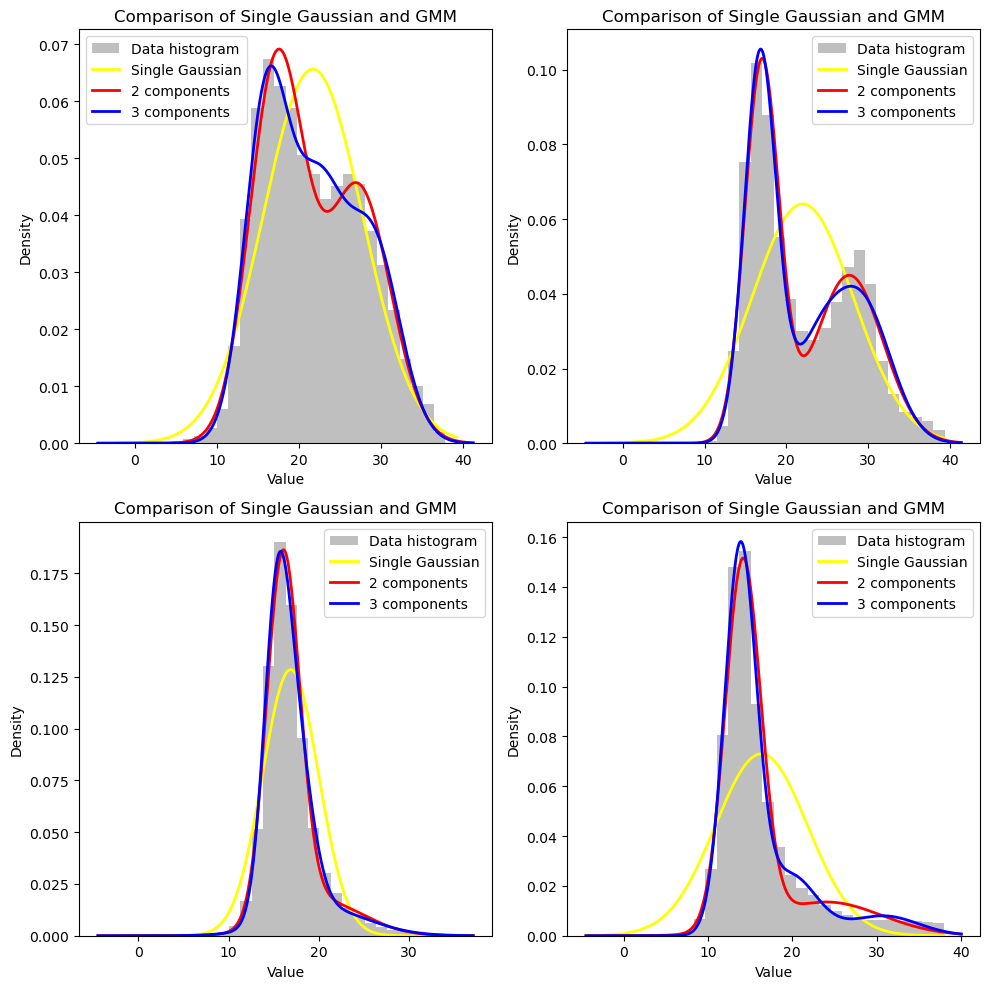

In [8]:
warnings.filterwarnings("ignore", message=".*libiomp.*libomp.*incompatible.*")

# Plot GMM
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, data in enumerate(sampled_data.values()):
    compare_gaussian_models(data, ax=axes[i], transform='boxcox', lamb=0.4)

plt.tight_layout()
plt.show()

## Filtering out low density data

In [9]:
filtered_data = {
    key: filter_low_density_data(seg_result_arrays[key])
    for key in seg_result_arrays
}

Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)




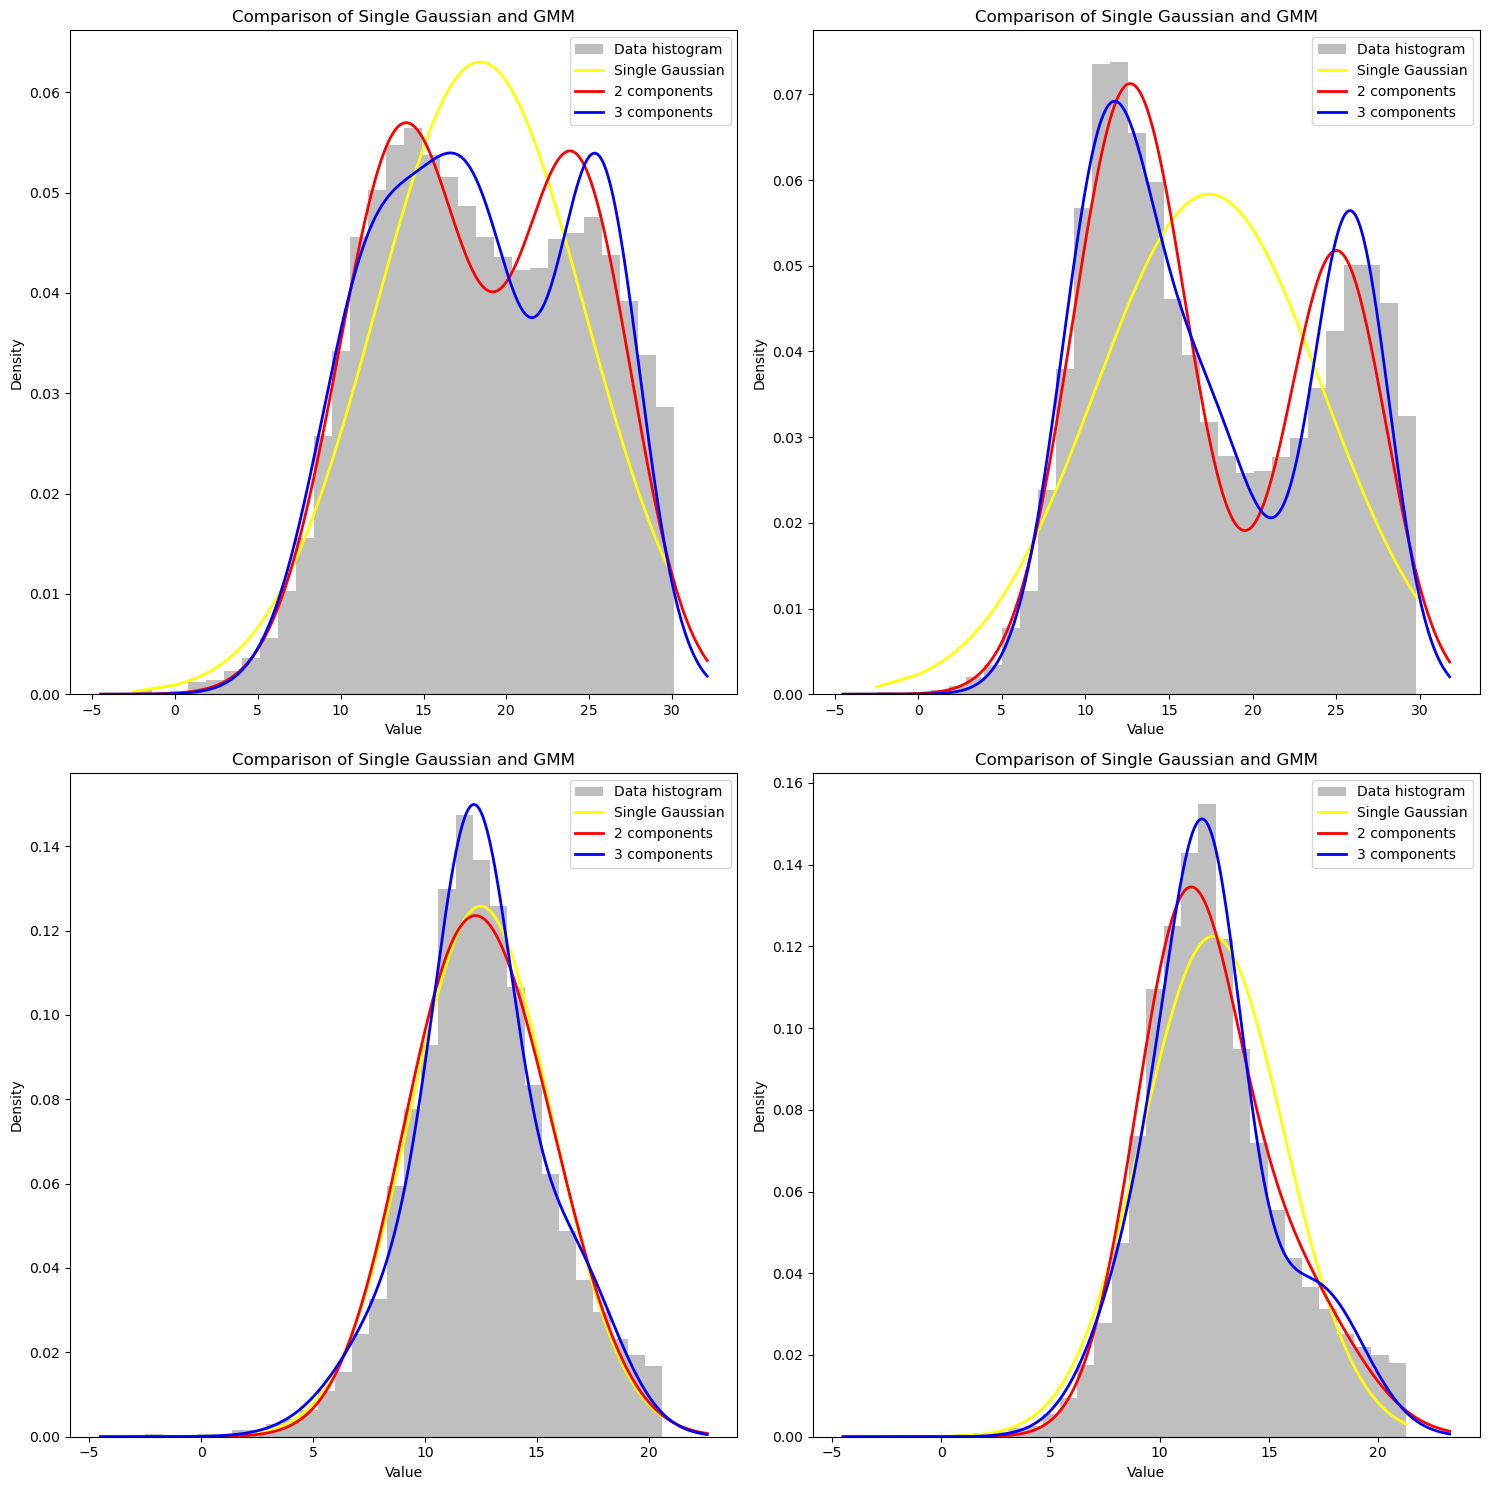

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, data in enumerate(filtered_data.values()):
    compare_gaussian_models(data, ax=axes[i], transform='boxcox', lamb=0.4)

plt.tight_layout()
plt.show()

## Run tests with transformed data

In [11]:
# Define the pairs for statistical tests
pairs = [
    ("002", "018_0", seg_result_arrays["002"], seg_result_arrays["018_0"]),
    ("000", "018_2", seg_result_arrays["000"], seg_result_arrays["018_2"]),
    ("018_0", "018_2", seg_result_arrays["018_0"], seg_result_arrays["018_2"]),
]

# Perform Kruskal-Wallis and Kolmogorov-Smirnov tests for each pair
for label1, label2, data1, data2 in pairs:
    # Filter the data
    data1_filtered = filter_low_density_data(data1)
    data2_filtered = filter_low_density_data(data2)
    
    # Kruskal-Wallis Test
    _, pval_kw = stats.kruskal(data1_filtered, data2_filtered)
    print(f'Kruskal-Wallis test between {label1} and {label2} median: p-value = {pval_kw}')
    
    # Kolmogorov-Smirnov Test
    _, pval_ks = stats.ks_2samp(data1_filtered, data2_filtered)
    print(f'Kolmogorov-Smirnov test between {label1} and {label2} distribution: p-value = {pval_ks}')


Kruskal-Wallis test between 002 and 018_0 median: p-value = 0.0
Kolmogorov-Smirnov test between 002 and 018_0 distribution: p-value = 0.0
Kruskal-Wallis test between 000 and 018_2 median: p-value = 0.0
Kolmogorov-Smirnov test between 000 and 018_2 distribution: p-value = 0.0
Kruskal-Wallis test between 018_0 and 018_2 median: p-value = 0.0
Kolmogorov-Smirnov test between 018_0 and 018_2 distribution: p-value = 0.0
